# Data Mining - Project
## Clustering Notebook
## Group Members
|Name|StudentID|
|:-----------:|:--------:|
|Fabio Lopes|20200597|
|Filipe Costa|20201041|
|Jorge Pereira|20201085|


In [1]:
import sys
!{sys.executable} -m pip install pyshp

You should consider upgrading via the 'C:\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import shapefile as shp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df_source = pd.read_csv('./data/donors.csv')
df_source.drop('Unnamed: 0', axis = 1, inplace = True)
df_NonOutlier = pd.read_csv('./Outputs/dataprep_NonOutliers.csv',index_col=0)
df_Outlier = pd.read_csv('./Outputs/dataprep_Outliers.csv',index_col=0)

C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (9,412) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
print(df_source.shape[0])
print(df_NonOutlier.shape[0])
print(df_Outlier.shape[0])

95412
85870
9542


In [6]:
def splitNumericAndCategorical(df):
    """Informs user on the total number of columns in the dataframe and splits it
       in 2 dataframes, one numerical and the other categorical."""
    df_num = df._get_numeric_data()
    df_cat = df.drop(df_num.columns, axis = 1)
    print(f"Total Columns: {df.shape[1]}")
    print(f"Numerical Columns: {df_num.shape[1]}")
    print(f"Categorical Columns: {df_cat.shape[1]}")
    return df_num,df_cat

# Clustering

In [7]:
# Selecting columns after analysis
ColumnsToKeep = ['INCOME','WEALTH1','RFA_2F','LASTGIFTAMOUNTCATEGORY']

df_NonOutlier_reduced = pd.DataFrame()
df_Outlier_reduced = pd.DataFrame()

for column in ColumnsToKeep:
    df_NonOutlier_reduced[column] = df_NonOutlier[column]
    df_Outlier_reduced[column] = df_Outlier[column]
    
df_NonOutlier = df_NonOutlier_reduced.copy()
df_Outlier = df_Outlier_reduced.copy()

In [8]:
df_clustering = df_NonOutlier.copy()

In [9]:
df_numeric, df_categorical = splitNumericAndCategorical(df_clustering)

Total Columns: 4
Numerical Columns: 4
Categorical Columns: 0


In [10]:
def ClusterMetrics(df,labels):
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
    
    Silhouette = silhouette_score(df, labels, metric='euclidean')
    print(f"Silhouette : {Silhouette}")
    CalinskiHarabasz = calinski_harabasz_score(df, labels)
    print(f"CalinskiHarabasz : {CalinskiHarabasz}")
    DaviesBouldin = davies_bouldin_score(df, labels)
    print(f"DaviesBouldin : {DaviesBouldin}")
    
    return [Silhouette, CalinskiHarabasz, DaviesBouldin]

In [11]:
def inertiaCalculationKmeans(df, numberClusters = range(1, 11)):
    inertiaResults = []
    for n_clus in numberClusters:
        kmclust = KMeans(n_clusters = n_clus, init = 'k-means++', n_init = 15, random_state=1)
        kmclust.fit(df)
        inertiaResults.append(kmclust.inertia_)
        
    plt.figure(figsize=(10,10))
    plt.plot(inertiaResults, color = 'g')
    plt.ylabel("Inertia")
    plt.xlabel("Number of clusters")
    plt.title("Inertia per clusters")
    plt.show()
    return inertiaResults

In [12]:
def tsneViz(df, labels = None,f_perplexity = 30.0, f_learning_rate = 200.0, plot=True):
    from sklearn.manifold import TSNE
    import seaborn as sns
    
    tsne = TSNE(n_components=2, 
                perplexity = f_perplexity,
                learning_rate = f_learning_rate
               ).fit_transform(df)
    
    #plot tsne
    if plot:
        fig = plt.figure(figsize = (10, 10))
        sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=labels, legend='full', palette = "Paired")
    
    return tsne

## KMeans

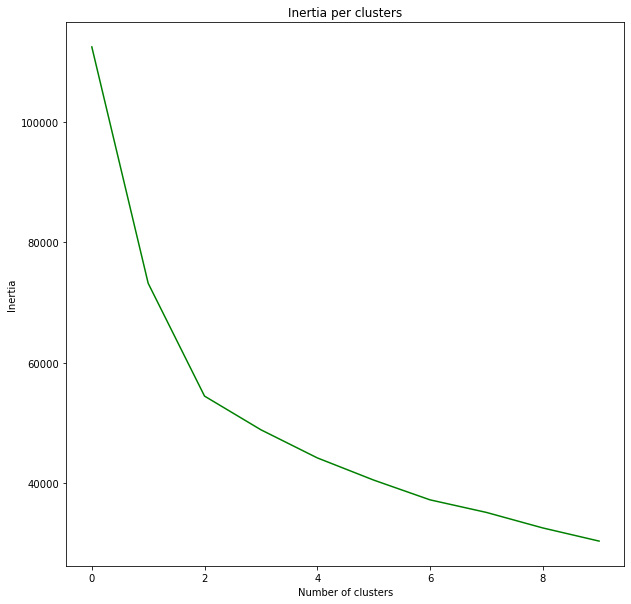

In [13]:
Inertia = inertiaCalculationKmeans(df_numeric)

In [14]:
KMeansAlgorithm = KMeans(n_clusters = 4, init = 'k-means++', n_init = 15, random_state=1).fit(df_numeric)

In [15]:
pd.DataFrame(KMeansAlgorithm.labels_).value_counts()

0    32180
2    29818
1    12288
3    11584
dtype: int64

In [16]:
ClusterMetrics(df_numeric,KMeansAlgorithm.labels_)

Silhouette : 0.26924942277118996
CalinskiHarabasz : 37262.65724383278
DaviesBouldin : 1.384560921332469


[0.26924942277118996, 37262.65724383278, 1.384560921332469]

# Labeling data and Return Outliers to the dataset

## Non Outlier Labelling

In [17]:
df_labeled = pd.concat([df_NonOutlier,
                        pd.DataFrame(KMeansAlgorithm.labels_,index=df_NonOutlier.index, columns = ['Cluster'])]
                       ,axis=1,
                       ignore_index=True)

columns = list(df_NonOutlier.columns.values)
columns.append('Cluster')
df_labeled.columns = columns

In [18]:
df_labeled

,INCOME,WEALTH1,RFA_2F,LASTGIFTAMOUNTCATEGORY,Cluster
0,-0.266667,0.200000,1.000000,-0.333333,3
1,0.666667,1.000000,-0.333333,1.000000,0
2,-0.333333,-0.777778,1.000000,-0.333333,3
3,-1.000000,-0.111111,1.000000,-0.333333,3
5,-0.133333,0.111111,-1.000000,0.333333,2
...,...,...,...,...,...
95405,0.066667,0.466667,-1.000000,1.000000,0
95406,0.666667,0.333333,1.000000,-1.000000,1
95407,-0.066667,0.066667,-1.000000,1.000000,2
95408,1.000000,1.000000,-1.000000,0.333333,0


## Outlier Labelling

In [19]:
df_numeric, df_categorical = splitNumericAndCategorical(df_Outlier)

outlierLabels = KMeansAlgorithm.predict(df_numeric)

df_OutlierLabeled = pd.concat([df_Outlier,
                            pd.DataFrame(outlierLabels,index=df_Outlier.index, columns = ['Cluster'])]
                           ,axis=1,
                           ignore_index=True)

columns = list(df_Outlier.columns.values)
columns.append('Cluster')
df_OutlierLabeled.columns = columns

Total Columns: 4
Numerical Columns: 4
Categorical Columns: 0


In [20]:
df_OutlierLabeled

,INCOME,WEALTH1,RFA_2F,LASTGIFTAMOUNTCATEGORY,Cluster
4,-0.333333,-0.555556,-0.333333,0.333333,2
12,0.000000,-0.555556,1.000000,-1.000000,3
30,-0.400000,-0.288889,0.333333,-1.000000,3
44,0.333333,0.777778,0.333333,0.333333,1
46,0.000000,0.066667,-1.000000,-0.333333,2
...,...,...,...,...,...
95368,-0.666667,-0.022222,-1.000000,0.333333,2
95373,0.666667,-0.555556,-1.000000,-0.333333,2
95396,0.333333,1.000000,0.333333,1.000000,1
95410,1.000000,0.733333,1.000000,0.333333,1


## Join outliers and Non Outliers

In [21]:
df_fullLabeled = pd.concat([df_labeled,df_OutlierLabeled],axis=0).sort_index(axis=0)

In [22]:
df_fullLabeled

,INCOME,WEALTH1,RFA_2F,LASTGIFTAMOUNTCATEGORY,Cluster
0,-0.266667,0.200000,1.000000,-0.333333,3
1,0.666667,1.000000,-0.333333,1.000000,0
2,-0.333333,-0.777778,1.000000,-0.333333,3
3,-1.000000,-0.111111,1.000000,-0.333333,3
4,-0.333333,-0.555556,-0.333333,0.333333,2
...,...,...,...,...,...
95407,-0.066667,0.066667,-1.000000,1.000000,2
95408,1.000000,1.000000,-1.000000,0.333333,0
95409,-0.066667,0.511111,0.333333,-0.333333,1
95410,1.000000,0.733333,1.000000,0.333333,1


## Visualize Results

In [23]:
df_numeric, df_categorical = splitNumericAndCategorical(df_fullLabeled)

Total Columns: 5
Numerical Columns: 5
Categorical Columns: 0


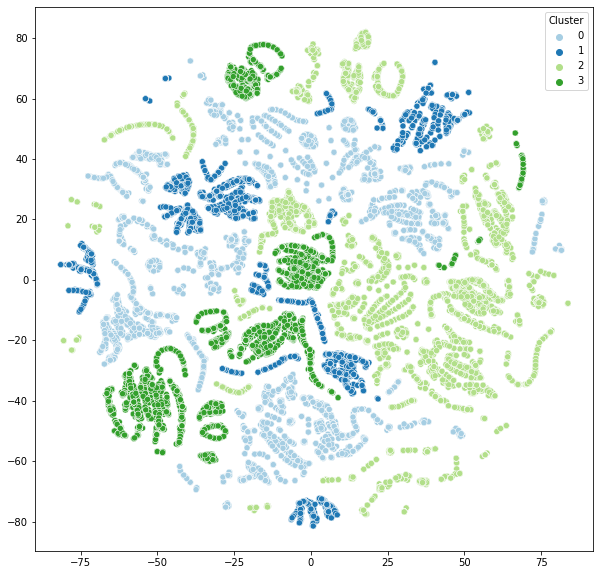

In [24]:
tsne = tsneViz(df_numeric, labels = df_numeric['Cluster'],f_perplexity = 100.0, f_learning_rate = 500.0)

In [25]:
df_tsne = pd.DataFrame(tsne,columns=['tsne1','tsn2'])

## Visualize with PCA

In [26]:
pca = PCA(n_components=2) # 
pca.fit(df_numeric)

columnsPCA = [f"PC_{i}" for i in range(1,3)]
df_PCA = pd.DataFrame(pca.transform(df_numeric),columns=columnsPCA)

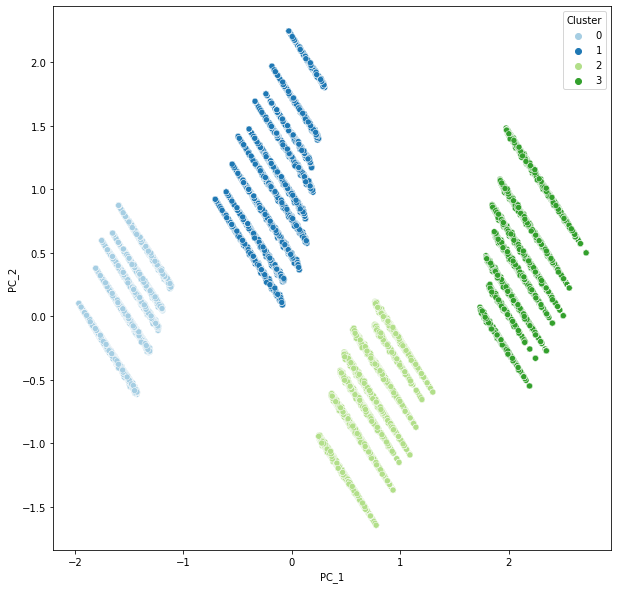

In [27]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x=df_PCA['PC_1'], y=df_PCA['PC_2'], hue=df_numeric['Cluster'], legend='full', palette = "Paired")

# Save Results

In [28]:
df_fullLabeled.to_csv('./Outputs/ReClustering_Labelled.csv')
df_tsne.to_csv('./Outputs/ReClustering_tsne.csv')

In [29]:
print(df_fullLabeled.shape[0])
print(df_tsne.shape[0])

95412
95412
